In [0]:
import tensorflow as tf
print(tf.__version__)


1.13.1


In [1]:
from google.colab import drive
drive.mount('/content/gdrive',force_remount=True)

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/gdrive


In [1]:
!ls "/content/gdrive/My Drive/NLPHW2"
root_path = '/content/gdrive/My Drive/NLPHW2/'

 bn2wn_mapping.txt		      parsed_anno_high-precision.txt
 combined.tab			      parsed_anno_TOM.txt
'Copy of HW2Code.ipynb'		      parsed_text_high-coverage.txt
'Copy of NLPHW2Code.ipynb'	      parsed_text_high-precision.txt
 final_embeddings_All_precision.pkl   parsed_text_TOM.txt
 HW2Code.ipynb			      tensorboard
 id2word_WN_first_HP_HC.pkl	      text_WNsyns_HP_HC.txt
 input_WNsyns_HP_HC_WS5.txt	      text_WNsyns_HP.txt
 MY_Sense_Embeddings.vec	      WN_syns_dic_HP_HC.pkl
 output_WNSyns_HP_HC_WS5.txt	      word2id_WN_first_HP_HC.pkl
 parsed_anno_high-coverage.txt


In [0]:
# Imports
from argparse import ArgumentParser
import os
import errno
from collections import Counter,deque
import codecs
import xml.etree.cElementTree as etree
#import gensim
import numpy as np
import pickle
import tensorflow as tf
import math
import matplotlib.pyplot as plt
from tensorflow.contrib.tensorboard.plugins import projector
from sklearn.manifold import TSNE
from tempfile import gettempdir


UNK = "<UNK_WORD>"

# path folders
TEXT_FILE_HP = root_path + 'parsed_text_high-precision.txt'
ANNO_FILE_HP = root_path + 'parsed_anno_high-precision.txt'
TEXT_FILE_HC = root_path + 'parsed_text_high-coverage.txt'
ANNO_FILE_HC = root_path + 'parsed_anno_high-coverage.txt'
TEXT_FILE_TOM = root_path + 'parsed_text_TOM.txt'
ANNO_FILE_TOM = root_path + 'parsed_anno_TOM.txt'
MAP_BN2WN_FILE = root_path + 'bn2wn_mapping.txt'

TEXT_WNSYNS_FILE = root_path+'text_WNsyns_HP_HC.txt'
ANNO_WNSYNS_FILE = root_path+'anno_WNSyns_HP_HC.txt'


INPUT_WNSYNS_FILE = root_path+'input_WNsyns_HP_HC.txt'
OUTPUT_WNSYNS_FILE = root_path+'output_WNSyns_HP_HC.txt'


In [4]:
# function for parsing large xml file and getting needed data from that.
root_path = 'D:/Data/Sapienza Master/Second Semester/NLP/NLP Second HomeWork/manoochehr_joodibigdello_1860273_nlp19hw2/'  
RESOURCE_PATH = root_path+'resources/'
Large_xml_file = RESOURCE_PATH+ 'eurosense.v1.0.high-coverage/EuroSense/eurosense.v1.0.high-coverage.xml'
Large_xml_TOM = RESOURCE_PATH+ 'train-o-matic-data/evaluation-framework-ims-training.xml'

def parseEuroSense_xml(filename):        
    context = etree.iterparse(filename, events=("start", "end"))   
    
    textfile = open(RESOURCE_PATH+'parsed_text_high-coverage.txt', "wb")
    annofile = open(RESOURCE_PATH+'parsed_anno_high-coverage.txt', "wb")
    
    for event, element in context:    
        if event == "start":        
            if element.tag =='text':
                if element.attrib['lang']=="en":
                    textfile.write(str(element.text).lower().encode())    
                
            if element.tag == "annotation":             
                if element.attrib['lang']=="en":                
                    annofile.write((str(element.text)+'<M.J>').lower().encode())                    
                    annofile.write((str(element.attrib['anchor'])+'<M.J>').lower().encode())                    
                    annofile.write((str(element.attrib['lemma'])+'<M.J>').lower().encode())
                    
        if event == "end":
            if element.tag == "annotations":    
                annofile.write('\n'.encode())                
            
            if element.tag == "sentence" :
                textfile.write('\n'.encode())        
        element.clear()
        
    textfile.close()
    annofile.close()


# parseEuroSense_xml(Large_xml_file)


FileNotFoundError: ignored

In [3]:
# -----------------------------------------------------------------------------
# function for getting dictionary of mapping file (bn:id,wn:id) and reverse dictionary of that
def BN_and_WN(mapping_file):
    BN_ID = []
    WN_ID = []
    with codecs.open(mapping_file,'rb') as f:        
        for line in f:            
            line_synsets = line.decode().strip().split('\t')
            BN_ID.append(line_synsets[0])
            WN_ID.append(line_synsets[1])    
    BN2WN_map_dic = dict(zip(BN_ID,WN_ID))
    return BN2WN_map_dic

BN2WN_map_dic = BN_and_WN(MAP_BN2WN_FILE)
WN2BN_map_dic = dict(zip(BN2WN_map_dic.values(), BN2WN_map_dic.keys()))
print(len(BN2WN_map_dic))
print(len(WN2BN_map_dic))



117653
117653


In [8]:
# # -----------------------------------------------------------------------------
def findall(p, s):
    '''Yields all the positions of
    the pattern p in the string s.'''
    i = s.find(p)
    while i != -1:
        yield i
        i = s.find(p, i+1)
        

def add_WN_senses2Text(text_file_HP, anno_file_HP, text_file_HC, anno_file_HC, text_file_TOM, anno_file_TOM):    
    text_syns_file = open(TEXT_WNSYNS_FILE, "wb")
    cnt = Counter() 
    
    anno_syns = open(anno_file_HP, "rb")    
    line_n = 0    
    with codecs.open(text_file_HP,'rb') as f:        
        for line in f: 
#             if line_n ==50:
#                 break
#             line_n+=1
            labels = anno_syns.readline().decode().strip().split('<m.j>') 
            line = ' '+ str(line)[slice(2,len(str(line))-3)]
            
            temp=[]    
            synsets = []
            for i in range(int(len(labels)/3)):
                synset=[]
                if BN2WN_map_dic.get(labels[i*3]) is not None:                    
                    synset.append(labels[i*3]) # bn:id
                    synset.append(labels[i*3+1]) # anchor
                    synset.append(labels[i*3+2]) # lemma
                    
                    # for making lemma's separated with space as oner single word (come to = come_to)
                    lemma_bnId_t = synset[2].strip().split(' ') 
                    lemma_bnId = ''                
                    for elem in lemma_bnId_t:
                        lemma_bnId += elem+'_'                                  
                    lemma_bnId += synset[0] # bn:id added to lemma_bn:id                      
                    synset[2]= lemma_bnId # put lemma_bn:id format in synsets for replacement.                    
                    synsets.append(synset)
            
            # deleting duplicate synsets from each sentence
            seen = set()
            new_synsets = []
            for item in synsets:
                t = tuple(item)
                if t not in seen:
                    new_synsets.append(item)
                    seen.add(t)
            synsets = new_synsets     
            
            # replace lemma_bn:id with anchor in text for synsets that you find in WN.            
            line_t=''            
            line_Wr=[]
            line_Wr.append(line)
            line_wr_n=0
            for elem in synsets:
                cnt[elem[2]] += 1 
                
                # in synset[1])+2 the +2 is because of one space before and one space after.
                temp = [(str(line_Wr[line_wr_n])[k:k+len(elem[1])+2]) for k in findall(' '+elem[1]+' ', line_Wr[line_wr_n])]        
                if len(temp) > 0: 
                    line_t = line_Wr[line_wr_n] # used in else part *
                    
                    line_Wr[line_wr_n] = str(line_Wr[line_wr_n]).replace(temp[0], ' '+elem[2]+' ') 
                    for i in range(len(line_Wr)):
                        line_Wr[i] = str(line_Wr[i]).replace(temp[0], ' '+elem[2]+' ')
                else:
                    # this part is for preventing removal of synsets like come_to for come to in cases that we have annotation for come or to in the senrence.                    
                    line_Wr.append(line_t)
                    line_wr_n += 1
                    temp = [(str(line_Wr[line_wr_n])[k:k+len(elem[1])+2]) for k in findall(' '+elem[1]+' ', line_Wr[line_wr_n])]
                    if len(temp) > 0: 
                        line_Wr[line_wr_n] = str(line_Wr[line_wr_n]).replace(temp[0], ' '+elem[2]+' ') 
                        for i in range(len(line_Wr)):
                            line_Wr[i] = str(line_Wr[i]).replace(temp[0], ' '+elem[2]+' ')
                                                
            for item_e in line_Wr:                
                text_syns_file.write((item_e[slice(1,len(item_e))]+'\n').encode())
                
    anno_syns.close()
    
    anno_syns = open(anno_file_HC, "rb")    
    line_n = 0    
    with codecs.open(text_file_HC,'rb') as f:        
        for line in f: 
#             if line_n ==50:
#                 break
#             line_n+=1
            labels = anno_syns.readline().decode().strip().split('<m.j>') 
            line = ' '+ str(line)[slice(2,len(str(line))-3)]
            
            temp=[]    
            synsets = []
            for i in range(int(len(labels)/3)):
                synset=[]
                if BN2WN_map_dic.get(labels[i*3]) is not None:                    
                    synset.append(labels[i*3]) # bn:id
                    synset.append(labels[i*3+1]) # anchor
                    synset.append(labels[i*3+2]) # lemma
                    
                    # for making lemma's separated with space as oner single word (come to = come_to)
                    lemma_bnId_t = synset[2].strip().split(' ') 
                    lemma_bnId = ''                
                    for elem in lemma_bnId_t:
                        lemma_bnId += elem+'_'                                  
                    lemma_bnId += synset[0] # bn:id added to lemma_bn:id                      
                    synset[2]= lemma_bnId # put lemma_bn:id format in synsets for replacement.                    
                    synsets.append(synset)
            
            # deleting duplicate synsets from each sentence
            seen = set()
            new_synsets = []
            for item in synsets:
                t = tuple(item)
                if t not in seen:
                    new_synsets.append(item)
                    seen.add(t)
            synsets = new_synsets              
            # replace lemma_bn:id with anchor in text for synsets that you find in WN.            
            line_t=''            
            line_Wr=[]
            line_Wr.append(line)
            line_wr_n=0
            for elem in synsets:
                cnt[elem[2]] += 1 
                # in synset[1])+2 the +2 is because of one space before and one space after.
                temp = [(str(line_Wr[line_wr_n])[k:k+len(elem[1])+2]) for k in findall(' '+elem[1]+' ', line_Wr[line_wr_n])]        
                if len(temp) > 0: 
                    line_t = line_Wr[line_wr_n]
                    line_Wr[line_wr_n-1] = str(line_Wr[line_wr_n-1]).replace(temp[0], ' '+elem[2]+' ') 
                    line_Wr[line_wr_n] = str(line_Wr[line_wr_n]).replace(temp[0], ' '+elem[2]+' ') 
                    for i in range(len(line_Wr)):
                        line_Wr[i] = str(line_Wr[i]).replace(temp[0], ' '+elem[2]+' ')
                else:
                    line_Wr.append(line_t)
                    line_wr_n += 1
                    temp = [(str(line_Wr[line_wr_n])[k:k+len(elem[1])+2]) for k in findall(' '+elem[1]+' ', line_Wr[line_wr_n])]
                    if len(temp) > 0: 
                        line_Wr[line_wr_n] = str(line_Wr[line_wr_n]).replace(temp[0], ' '+elem[2]+' ') 
                        for i in range(len(line_Wr)):
                            line_Wr[i] = str(line_Wr[i]).replace(temp[0], ' '+elem[2]+' ')
                                                
            for item_e in line_Wr:                
                text_syns_file.write((item_e[slice(1,len(item_e))]+'\n').encode())
#                 print(item_e[slice(1,len(item_e))]+'\n')
                
    anno_syns.close()

    print('add_WN_senses2Text Finished ....... ')
    return cnt

# it returns a Counter of senses and we use that for making our dictionary of senses
cnt_All_syns = add_WN_senses2Text(TEXT_FILE_HP, ANNO_FILE_HP, TEXT_FILE_HC, ANNO_FILE_HC, TEXT_FILE_TOM, ANNO_FILE_TOM)


add_WN_senses2Text Finished ....... 


In [0]:
# code for making dictionary of senses
def get_WNsyns_dic(cnt_wn):
    WN_syns, _ = list(zip(*cnt_wn.items()))
    WN_syns_dic = dict(zip(WN_syns, range(len(WN_syns))))
    return WN_syns_dic
    
WN_syns_dic = get_WNsyns_dic(cnt_All_syns)
print(len(WN_syns_dic))



158689
158689


In [0]:
# code for making dictionary and reverse dictionary of all words and senses with senses at first folllowing by other words.
def get_word2id(filename,cnt_All_syns):              
    with codecs.open(filename,'rb') as f:        
        for line in f:
            line = line.decode().strip().split(' ')  
            for word in line:
                cnt_All_syns[word] += 1            
    
    x=[UNK]
    for word in x:
        cnt_All_syns[word] += 1   
        
    words, _ = list(zip(*cnt_All_syns.items()))
    word2id = dict(zip(words, range(len(words))))
    
    return word2id

word2id = get_word2id(TEXT_WNSYNS_FILE, cnt_All_syns)
id2word = dict(zip(word2id.values(), word2id.keys()))
    
print(len(word2id))
print(word2id[UNK])


269340
269339


In [0]:
# Save PKL files
with open(root_path+'WN_syns_dic_HP_HC.pkl', "wb") as outfile:
    pickle.dump(WN_syns_dic, outfile)

with open(root_path+'word2id_WN_first_HP_HC.pkl', "wb") as outfile:
    pickle.dump(word2id, outfile)

with open(root_path+'id2word_WN_first_HP_HC.pkl', "wb") as outfile:
    pickle.dump(id2word, outfile)    


In [4]:
# code for loading Saved PKL files for speedUp the processes
WN_syns_dic = pickle.load(open(root_path+'WN_syns_dic_HP_HC.pkl', "rb"))
print(len(WN_syns_dic))
word2id = pickle.load(open(root_path+'word2id_WN_first_HP_HC.pkl', "rb"))
id2word = pickle.load(open(root_path+'id2word_WN_first_HP_HC.pkl', "rb"))
print(len(word2id))


158689
269340


In [0]:
# Function to generate a training data for the skip-gram model. I write All <sense, context word> 
# pairs in files for reafing them sequentially whil training because the amount of data was 1.5 Bilion 
# and colab kernel are crashed during process of storing data as array or dictionary.
def generate_train_data(text_file, window_size): 
    input_file = open(INPUT_WNSYNS_FILE, "wb")
    output_file = open(OUTPUT_WNSYNS_FILE, "wb")
    with codecs.open(text_file,'rb') as f:
        line_num = 0
        for line in f:  
            data = line.decode().strip().split(' ')
            for j in range(len(data)):
                if WN_syns_dic.get(data[j]) is not None: 
                    SynW = data[j]
                    if j > window_size:
                        for k in range(window_size): # left part
                            input_file.write(str(word2id.get(SynW,word2id[UNK])).encode())
                            input_file.write('\n'.encode())
                            output_file.write(str(word2id.get(data[j-window_size+k],word2id[UNK])).encode())
                            output_file.write('\n'.encode())
    
                        for k in range(window_size): # right part
                            if j+k < len(data):
                                input_file.write(str(word2id.get(SynW,word2id[UNK])).encode())
                                input_file.write('\n'.encode())
                                output_file.write(str(word2id.get(data[j+k],word2id[UNK])).encode())
                                output_file.write('\n'.encode())

                    elif j <= window_size:
                        for k in range(window_size): # left part
                            if j-window_size+k >=0:
                                input_file.write(str(word2id.get(SynW,word2id[UNK])).encode())
                                input_file.write('\n'.encode())
                                output_file.write(str(word2id.get(data[j-window_size+k],word2id[UNK])).encode())
                                output_file.write('\n'.encode())
    
                        for k in range(window_size): # right part
                            if j+k < len(data):
                                input_file.write(str(word2id.get(SynW,word2id[UNK])).encode())
                                input_file.write('\n'.encode())
                                output_file.write(str(word2id.get(data[j+k],word2id[UNK])).encode())
                                output_file.write('\n'.encode())

    print("training data is ready and saved in file")                                


window_size = 10
generate_train_data(TEXT_WNSYNS_FILE, window_size)

  

In [0]:
# some of Hyperparameters for tensorflow model.
vocab_size = len(WN_syns_dic)
print(vocab_size)
batch_size = 512 
embedding_size = 100  # Dimension of the embedding vector.
num_sampled = 64  # Number of negative examples to sample.


158689


In [0]:
# -----------------------------------------------------------------------------  
# I used word2vec implementation of tensorflow website as my Inspiration.
with tf.variable_scope('inputs', reuse=tf.AUTO_REUSE):
    train_inputs = tf.placeholder(tf.int32, shape=[None])      
    train_labels = tf.placeholder(tf.int32, shape=[None, 1])

# Look up embeddings for inputs.
with tf.variable_scope('embeddings', reuse=tf.AUTO_REUSE):
    embeddings = tf.Variable(tf.random_uniform([vocab_size, embedding_size], -1.0, 1.0))
    embed = tf.nn.embedding_lookup(embeddings, train_inputs)        

# # Construct the variables for the softmax Sampling loss
# with tf.variable_scope('weights', reuse=tf.AUTO_REUSE):
#     softmax_w = tf.Variable(tf.truncated_normal((vocab_size, embedding_size))) 
    
# with tf.variable_scope('biases', reuse=tf.AUTO_REUSE):
#     softmax_b = tf.Variable(tf.zeros(vocab_size), name="softmax_bias")

# # Calculate the loss using negative sampling
# with tf.variable_scope('loss', reuse=tf.AUTO_REUSE):
#     loss = tf.reduce_mean(
#        tf.nn.sampled_softmax_loss(
#             weights=softmax_w,
#             biases=softmax_b,
#             labels=train_labels,
#             inputs=embed,
#             num_sampled=num_sampled,
#             num_classes=vocab_size))
    
# Construct the variables for the NCE loss
with tf.variable_scope('weights', reuse=tf.AUTO_REUSE):
    nce_weights = tf.Variable(
      tf.truncated_normal([vocab_size, embedding_size],
                          stddev=1.0 / math.sqrt(embedding_size)))
with tf.variable_scope('biases', reuse=tf.AUTO_REUSE):
    nce_biases = tf.Variable(tf.zeros([vocab_size]))


# Compute the average NCE loss for the batch.
# tf.nce_loss automatically draws a new sample of the negative labels each
# time we evaluate the loss.
with tf.variable_scope('loss', reuse=tf.AUTO_REUSE):
    loss = tf.reduce_mean(
      tf.nn.nce_loss(
          weights=nce_weights,
          biases=nce_biases,
          labels=train_labels,
          inputs=embed,
          num_true=1,
          num_sampled=num_sampled,
          num_classes=vocab_size))

## Learning rate decay 
# global_step = tf.Variable(0, trainable = False) 
# learningRate = tf.train.exponential_decay(learning_rate = 0.1, 
#                global_step = global_step, decay_steps = 1000, decay_rate = 0.95, staircase = True)

# Construct the SGD optimizer using a learning rate of 1.0
with tf.variable_scope('optimizer', reuse=tf.AUTO_REUSE):
    optimizer = tf.train.GradientDescentOptimizer(learning_rate=1.0).minimize(loss)

# normalize embeddings    
norm = tf.sqrt(tf.reduce_sum(tf.square(embeddings), 1, keepdims=True))
normalized_embeddings = embeddings / norm    

# Add variable initializer.
init = tf.global_variables_initializer()

# Create a saver.
saver = tf.train.Saver()


Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Create a `tf.sparse.SparseTensor` and use `tf.sparse.to_dense` instead.
Instructions for updating:
Use tf.cast instead.


In [0]:
num_steps = 1
  
LOG_DIR = root_path + 'tensorboard'

SUBSET_MODEL_ADD = LOG_DIR + '/Saved_model_1.3282439399313053/.' # None at first step
print(SUBSET_MODEL_ADD)


/content/gdrive/My Drive/NLPHW2/tensorboard/Saved_model_0.5718795662686722/.


In [0]:
with tf.Session() as session:
    if SUBSET_MODEL_ADD is not None:
        # we restore model for continue the training.
        saver = tf.train.Saver()
        saver.restore(session, tf.train.latest_checkpoint(SUBSET_MODEL_ADD))
        print('model restored')
    else:
        # We must initialize all variables before we use them.
        init.run()
        print('Initialized')
        
    print ('start session is ok ....')    
    for step in range(num_steps):
        average_loss = 0
        loss_val=[]
        line_num = 0
        batch_inputs = []
        batch_labels = []
        L_print = 0
        
        input_file = open(INPUT_WNSYNS_FILE, "rb")
        with open(OUTPUT_WNSYNS_FILE, "rb") as output_file:  
            for line_out in output_file:
                line_in = input_file.readline().decode()
                line_out = line_out.decode()
                batch_inputs.append(line_in[slice(0,len(line_in)-1)])
                batch_labels.append(line_out[slice(0,len(line_out)-1)])
                line_num +=1 
                # Reading files from file and when we read batch_size lines of data we feed it to our model and then start to read another lines.
                if line_num % batch_size == 0:
                    batch_inputs = np.asarray(batch_inputs).flatten()
                    batch_labels = np.asarray(batch_labels)
                    batch_labels = batch_labels.reshape((batch_labels.shape[0], 1))
                    
                    feed_dict = {train_inputs: batch_inputs, train_labels: batch_labels}                    
                        
                        
                    _, loss_val_b = session.run([optimizer, loss],
                                                     feed_dict=feed_dict)
                    loss_val.append(loss_val_b)
                    
                    batch_inputs = []
                    batch_labels = []
                    
                    # printing Average loss every 10000*batch size
                    if line_num % (10000*batch_size) == 0:
                        L_print += 1                        
                        line_num = 0
                        print('Average loss at 10000 base batch ', L_print, ': ', np.mean(loss_val,dtype=float) )
        
        # overall loss of step calculation
        average_loss +=np.mean(loss_val,dtype=float) 
                    
        # The average loss is an estimate of the loss over the last batches in every step
        print('Average loss at step ', step, ': ', average_loss)
                
        # Save the model for checkpoints.                
        save_path = saver.save(session, LOG_DIR + '/Saved_model_{}/model.ckpt'.format(average_loss))        
        print("Model saved in path: %s" % save_path) 
    
        # save embeddings
        final_embeddings = normalized_embeddings.eval()
        
        input_file.close()
        
    # Write corresponding labels for the embeddings. for using in projector.tensorflow website.
    with open(LOG_DIR + '/metadata.tsv', 'w') as f:
        for i in range(vocab_size):
            f.write(id2word[i] + '\n')
                
    

Instructions for updating:
Use standard file APIs to check for files with this prefix.
INFO:tensorflow:Restoring parameters from /content/gdrive/My Drive/NLPHW2/tensorboard/Saved_model_0.5718795662686722/model.ckpt
model restored
start session is ok ....
Average loss at 10000 base batch  1 :  0.4791103801526129
Average loss at 10000 base batch  2 :  0.46868028731448574
Average loss at 10000 base batch  3 :  0.42731750031258947
Average loss at 10000 base batch  4 :  0.4003170116999143
Average loss at 10000 base batch  5 :  0.39957542299092397
Average loss at 10000 base batch  6 :  0.4081219718590825
Average loss at 10000 base batch  7 :  0.4108543014630526
Average loss at 10000 base batch  8 :  0.41421393372831006
Average loss at 10000 base batch  9 :  0.41450990246317104
Average loss at 10000 base batch  10 :  0.4168484487314714
Average loss at 10000 base batch  11 :  0.4182715897738177
Average loss at 10000 base batch  12 :  0.4145372080357246
Average loss at 10000 base batch  13 :  0

In [0]:
!tensorboard --logdir LOG_DIR

TensorBoard 1.13.1 at http://f6fa5ce98d9c:6006 (Press CTRL+C to quit)
^C


In [0]:
print(len(final_embeddings))

# Write embeddings in tsv format for using projector.tensorflow website for visualization.
with open(LOG_DIR + '/embeddings_vec.tsv', 'w') as f:
    for i in range(vocab_size):
        for elem in final_embeddings[i]:
            f.write(str(elem) + '\t')
        f.write('\n')


# save final embeddings as PKL file
with open(root_path+'final_embeddings_All_precision.pkl', "wb") as outfile:
    pickle.dump(final_embeddings, outfile)
    
# final_embeddings = pickle.load(open(root_path+'final_embeddings_All_precision.pkl', "rb"))    

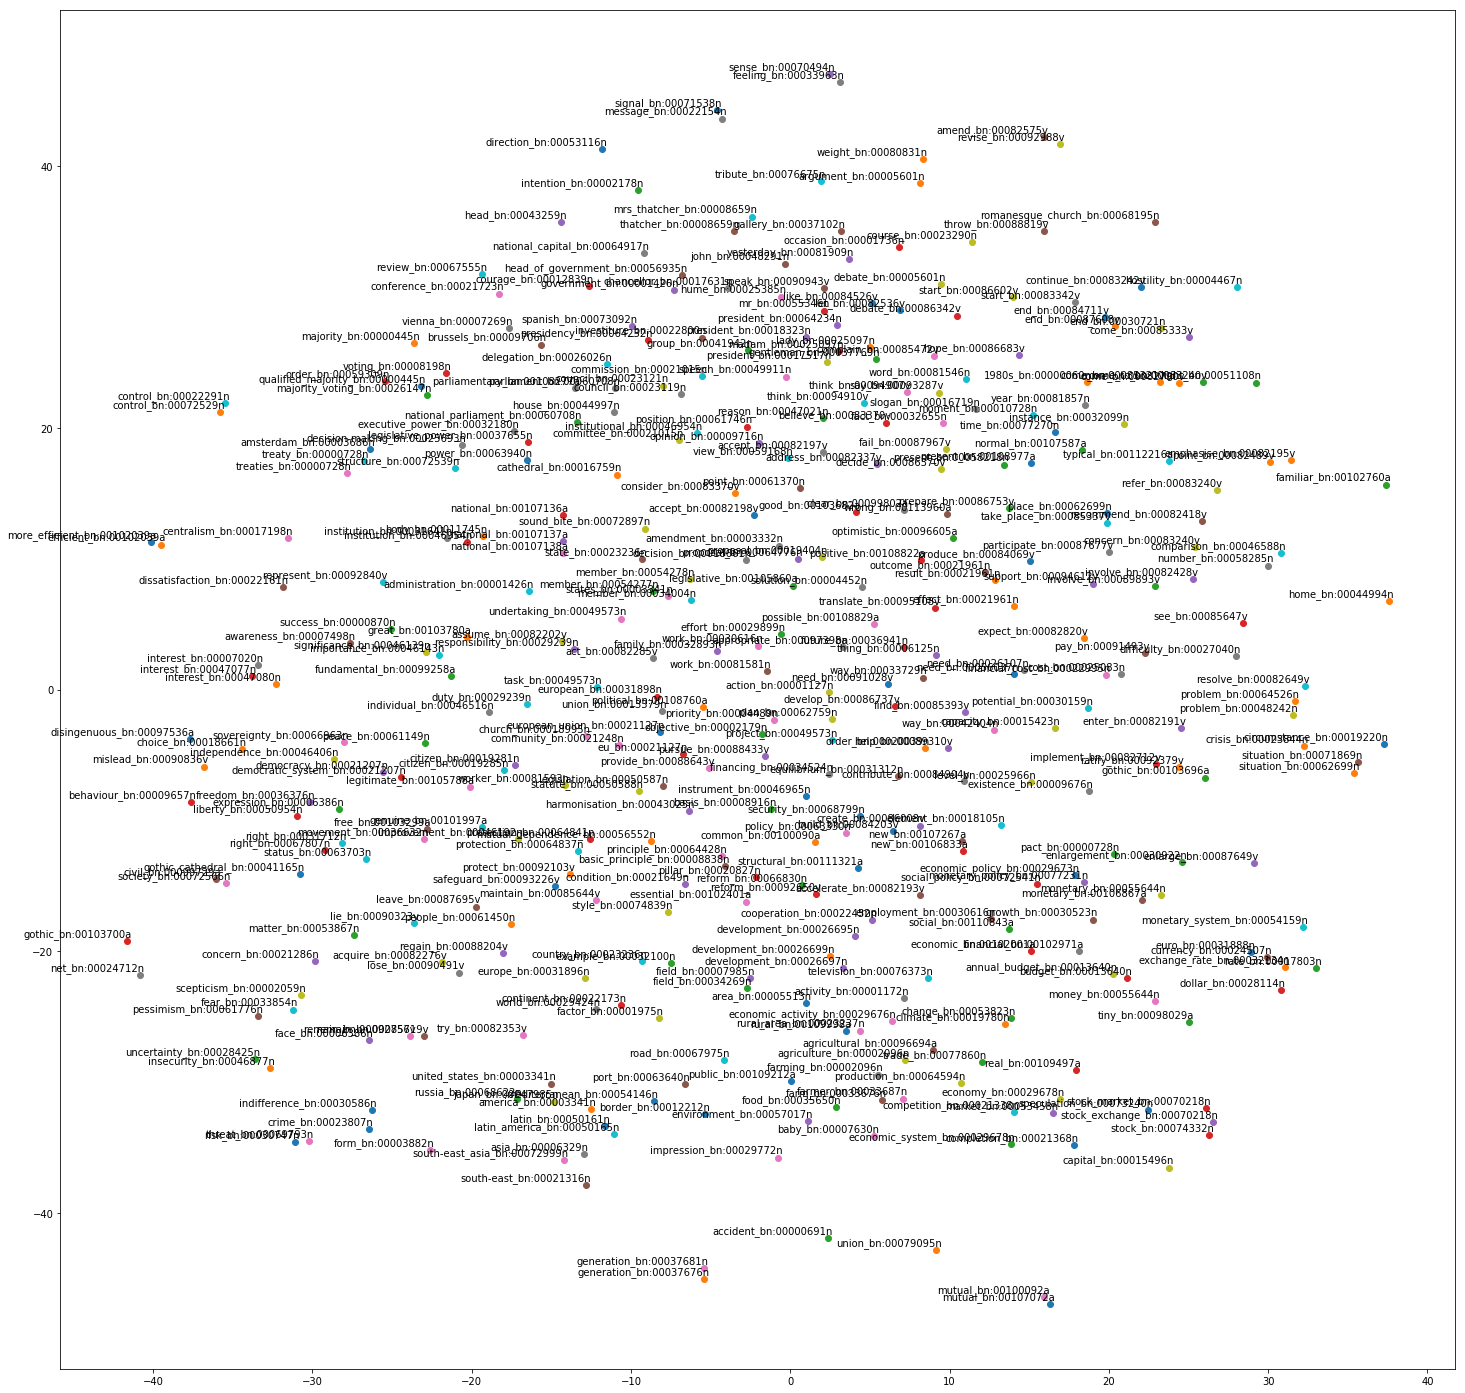

In [0]:
# code for plotting TSNE firmat plot
def plot_with_labels(low_dim_embs, labels, filename):
        assert low_dim_embs.shape[0] >= len(labels), 'More labels than embeddings'
        plt.figure(figsize=(25, 25))  # in inches
        
        for i, label in enumerate(labels):
            x, y = low_dim_embs[i, :]
            plt.scatter(x, y)
            plt.annotate(
                label,
                xy=(x, y),
                xytext=(5, 2),
                textcoords='offset points',
                ha='right',
                va='bottom')

        plt.savefig(filename)
                        
tsne = TSNE(perplexity=30, n_components=2, init='pca', n_iter=4000, method='exact', random_state=32)
plot_only = 400
low_dim_embs = tsne.fit_transform(final_embeddings[:plot_only, :])
labels = [id2word[i] for i in range(plot_only)]

plot_with_labels(low_dim_embs, labels, os.path.join(gettempdir(),'tsne.png'))


In [0]:
# function for creating word2vec format sense Embedding's.
def map_embedVec2Sens():
    labels = [id2word[i] for i in range(len(WN_syns_dic))]
    sense_embeddings=[]
    sense_embeddings.append(str(len(WN_syns_dic)) + " " + str(embedding_size))
    for i in range(len(final_embeddings)):
        X = labels[i]
        for j in range(len(final_embeddings[i])):
            X += " " + str(final_embeddings[i][j])
        sense_embeddings.append(X)
    
    return sense_embeddings


In [0]:
# function for writing .vec file of sense Embedding's
def writeW2V_file(file_name):
    with open(file_name, 'wb') as f: 
        for elem in sense_embeddings:
            f.write(elem.encode())
            f.write('\n'.encode())

In [0]:
# function for splitting lemma_bn:Id format to separated lemma format.
def get_lemma(lemma_bnId):
    lemma = lemma_bnId.split('_bn:')
    if len(lemma) > 0:
        lemma_ = lemma[0].split('_') 
        lemma_t = ''                
        for elem in lemma_:
            lemma_t += elem + ' '                                  
        lemma = lemma_t[0:len(lemma_t)-1]
    else:
        lemma = None        
    return lemma

In [0]:
# function for performing cosine similarity of two list of senses of 2 word. return cosine similarity.
from sklearn.metrics.pairwise import cosine_similarity
def cos_sim_senses(word1_senses, word2_senses):
    score = -1
    for word1_sens in word1_senses:
        for word2_sens in word2_senses:
            word1_sens = np.asarray(word1_sens).reshape(1,-1)
            word2_sens = np.asarray(word2_sens).reshape(1,-1)          
            score = max(score, cosine_similarity(word1_sens, word2_sens)[0][0])    
    return score

In [0]:
# function for getting list of senses of 2 word from sense Embedding's and then computing their 
# cosine similarity and returning score
def get_sense_similarity(word1, word2, sense_embeddings):
    word1_senses = []
    word2_senses = []
    for i in range(len(sense_embeddings)-1):
#        if i == 100:
#            break
        # -1 is for ignoring first row of word2vec.vec format
        line = sense_embeddings[i+1].strip().split(' ')
        lemma_bnId = line[0]
        lemma = get_lemma(lemma_bnId)
        if lemma == word1:
            word1_senses.append(line[(slice(1,len(line)))])
        if lemma == word2:
            word2_senses.append(line[(slice(1,len(line)))])
            
    score = cos_sim_senses(word1_senses, word2_senses)        
    return score

In [0]:
# function for reading combined.tab format from word-sim_353 for testing.
import csv
def get_test_data(filename):
    test_data = []
    with open(filename, newline = '') as f:                                                                                          
        f_reader = csv.reader(f, delimiter='\t')    
        for line in f_reader:
            test_data.append(line)
            
    return test_data[slice(1,len(test_data))] 

In [0]:
# function for computing cosine similarity of 2 word based on their senses and then computing spearman correlation for that words
# in a format that Explained in HW2 pdf. 
from scipy.stats import spearmanr
import random
def get_test_spearman_score(test_data):
    pred_sim = []
    true_sim = []
    UNK_words=[]
    for i in range(len(test_data)):
        word1 = test_data[i][0].lower()    
        word2 = test_data[i][1].lower()
        sim = get_sense_similarity(word1, word2, sense_embeddings)
        true_sim.append(float(test_data[i][2]))
        if sim ==-1:
            UNK_words.append(word1+" : "+word2)
            print('UNK: ', word1 + " : " + word2)
            sim = random.randint(0,1000)/1000
            
        pred_sim.append(sim)        
        print(i,' : ','word1:',word1, ' word2:',word2,' true_sim:',true_sim[i],' pred_sim:',pred_sim[i])        
                        
    spearman_score = spearmanr(true_sim, pred_sim)[0]
    return spearman_score if not np.isnan(spearman_score) else 0.0


In [0]:
# getting sense Embeddings in w2v format
sense_embeddings = map_embedVec2Sens()
# writing sense_embeddings in .vec file           
writeW2V_file(root_path+'MY_Sense_Embeddings.vec')

In [0]:
# loading ense Embeddings file with gensim.
from gensim.models import KeyedVectors
model = KeyedVectors.load_word2vec_format(root_path+'MY_Sense_Embeddings.vec', binary=False)

## code for save and load model again with gensim
# model.save(RESOURCE_PATH + 'model.model')
# model_w2v = KeyedVectors.load(RESOURCE_PATH + 'model.model')

# print(model.most_similar(positive=['president_bn:00064234n'],topn=10))

# sample test
score = get_sense_similarity('disaster', 'area', sense_embeddings)      
print(score)


/usr/local/lib/python3.6/dist-packages/gensim/matutils.py:737: FutureWarning: Conversion of the second argument of issubdtype from `int` to `np.signedinteger` is deprecated. In future, it will be treated as `np.int64 == np.dtype(int).type`.
  if np.issubdtype(vec.dtype, np.int):


[('mr_bn:00055346n', 0.7587555050849915), ('lady_bn:00025097n', 0.7234150171279907), ('madam_bn:00025097n', 0.712024450302124), ('gentleman_bn:00037769n', 0.7034037709236145), ('prime_minister_bn:00017631n', 0.6925813555717468), ('president_bn:00018323n', 0.688895583152771), ('president_bn:00017517n', 0.6814703941345215), ('vice-president_bn:00079435n', 0.6586853265762329), ('prime_bn:00064385n', 0.6559879779815674), ('european_bn:00031898n', 0.6517962217330933)]
0.501566378347961


In [0]:
# getting test data and computing spearman correlation.
test_data = get_test_data(root_path + 'combined.tab')
    
spearman_score = get_test_spearman_score(test_data)       
        
print(spearman_score)


0  :  word1: love  word2: sex  true_sim: 6.77  pred_sim: 0.4723218887628761
1  :  word1: tiger  word2: cat  true_sim: 7.35  pred_sim: 0.500193194980531
2  :  word1: tiger  word2: tiger  true_sim: 10.0  pred_sim: 1.0000000000000002
3  :  word1: book  word2: paper  true_sim: 7.46  pred_sim: 0.5328685480000968
4  :  word1: computer  word2: keyboard  true_sim: 7.62  pred_sim: 0.3798309148505357
5  :  word1: computer  word2: internet  true_sim: 7.58  pred_sim: 0.4425446206214959
6  :  word1: plane  word2: car  true_sim: 5.77  pred_sim: 0.4742306503493271
7  :  word1: train  word2: car  true_sim: 6.31  pred_sim: 0.5459086281043328
8  :  word1: telephone  word2: communication  true_sim: 7.5  pred_sim: 0.49061786509033334
9  :  word1: television  word2: radio  true_sim: 6.77  pred_sim: 0.6562115683689577
10  :  word1: media  word2: radio  true_sim: 7.42  pred_sim: 0.4348732002793507
11  :  word1: drug  word2: abuse  true_sim: 6.85  pred_sim: 0.5642603096350215
12  :  word1: bread  word2: butte